CNNではフィルターの表現を学習している。<br>
チャネル数は３＊３のフィルターを64個準備するということ、チャネルの数だけフィルターがある。ちなみに3＊3でフィルターを行うと画像は縮小される。もし縮小するのをやめたい場合は、パディング（画像の周りに余白部分を作る）を行い、作業を行っていく。<br>
プーリングとは…画像の解像度を下げるもの、（128、128）が（68、68）になるみたいな感じです。このピクセルをまとめるときにはさまざまなルールがあるが最大値を採用してプーリングを行うのがMAX_POOLING

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from  torchvision import datasets , transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),#Tensorclassに変えている。ChannelFirsｔに変換している。
                                transforms.Normalize((0.5,) , (0.5 , ))#平均値0.5標準偏差0.5になるように正規化を行っている。

])
#学習用データセット
train_dataset = datasets.CIFAR10(root="./data" , train=True , download=True , transform=transform)
#検証用データセット
validation_dataset = datasets.CIFAR10(root="./data" , train=True , download=True , transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
names = ("plane", "car" , "bird" , "cat" , "deer" , "dog" , "frog" , "horse" , "ship" , "truck")


In [6]:
train_dataloader = DataLoader(train_dataset , batch_size=32 , shuffle=True)
validation_dataloader = DataLoader(validation_dataset , batch_size=32 , shuffle=False)

In [7]:
data_iter = iter(train_dataloader)

In [8]:
imgs , labels = data_iter.next()

In [9]:
labels

tensor([7, 1, 0, 3, 3, 0, 6, 7, 3, 0, 9, 6, 2, 7, 3, 5, 1, 9, 5, 9, 7, 6, 3, 2,
        9, 6, 7, 3, 0, 8, 7, 5])

In [10]:
imgs.size()#バッチ、チャネル、ｈ、ｗ

torch.Size([32, 3, 32, 32])

In [11]:
img = imgs[0]
img_permute = img.permute(1,2,0)
img_permute = 0.5 * img_permute + 0.5
img_permute = np.clip(img_permute , 0, 1)#0~1の間に収めるようにしている。

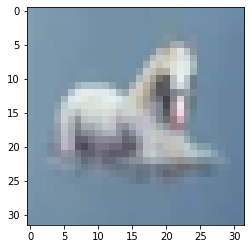

In [12]:
plt.imshow(img_permute)

In [15]:
names = ("plane", "car" , "bird" , "cat" , "deer" , "dog" , "frog" , "horse" , "ship" , "truck")
labels[0]

tensor(7)

In [16]:
#CNNのクラスの定義を行う。


class CNN(nn.Module):
    def __init__(self , num_classes):#10個のクラスがあるのでnum_classesには10を代入する。
        super().__init__()
        self.features = nn.Sequential(
            #64個のフィルターを使用していく。カーネルサイズは５なので5＊5のフィルターになる。
            #5＊5のフィルターを使用するので画像の大きさを変えないためにpadding=2としている。ちなみにkarnel_sizeが3の時はpaddingは１
            nn.Conv2d(in_channels=3 , out_channels=64 , kernel_size=5,padding=2),#畳み込みを行っている
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#元の画像は32＊32なのでMAX_POOLINGを行うことによって16＊16の画像に縮小される。

            nn.Conv2d(in_channels= 64, out_channels=128 , kernel_size=3,padding=1),#inchannelsは前のout_channelsと同じ数でないとならない。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#8*8
            
            nn.Conv2d(in_channels=128 , out_channels=256 , kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#4*4

            nn.Conv2d(in_channels=256 , out_channels=128 , kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
        )

        #in_featuresには最後のMAX_POOLINGのチャネルの数（128）＊最後に出力されるMAX_POOLINGの大きさ（４＊４）
        #out_featuresは出力なので今回10クラスの分類を行うため10になる。
        self.classifier = nn.Linear(in_features=4*4*128,out_features=num_classes)#①

    def forward(self , x):
        x = self.features(x)#ここで出てくるのはｘ＝（32、128、４、４）
        x = x.view(x.size(0) , -1)#ここで一次のベクトル化を行っている。(32,4*4*128)
        x = self.classifier(x)#一時のベクトルに変換したものをここで①に入れている
        return x

In [17]:
model = CNN(10)#今回は10を引数に入れないといけないので入れた。
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = 0.001 , weight_decay=5e-4 )#weight_decayL2正則化を行っている。

In [21]:
num_epochs = 15
losses = []
accs = []

#検証用の損失と正解率
val_losses=[]
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs , labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output , labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output , dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

    #ここからvalidation loopを行っていく
    val_running_loss = 0.0
    val_running_acc = 0.0

    for val_imgs , val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output , val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output , dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch;{} , loss: {} , acc:{}, val loss: {} , val acc: {}".format(epoch ,running_loss , running_acc , val_running_loss , val_running_acc))

epoch;0 , loss: 0.9590054174988832 , acc:0.6610684394836426, val loss: 0.7911658187897939 , val acc: 0.7256677746772766
epoch;1 , loss: 0.7794006428158748 , acc:0.7261476516723633, val loss: 0.6419829540884198 , val acc: 0.7767314314842224
epoch;2 , loss: 0.675121105887992 , acc:0.7643954157829285, val loss: 0.5908186525792856 , val acc: 0.7934061288833618
epoch;3 , loss: 0.5964713940827113 , acc:0.7921065092086792, val loss: 0.535609615407765 , val acc: 0.8171384930610657
epoch;4 , loss: 0.5372756691464841 , acc:0.813899576663971, val loss: 0.42729194958051353 , val acc: 0.8535468578338623
epoch;5 , loss: 0.48918029547729175 , acc:0.8272352814674377, val loss: 0.4264590420968168 , val acc: 0.8523872494697571
epoch;6 , loss: 0.44459063966859247 , acc:0.8430502414703369, val loss: 0.360761260097788 , val acc: 0.8787187933921814
epoch;7 , loss: 0.40627147662033275 , acc:0.8574656248092651, val loss: 0.32403357622528867 , val acc: 0.8929542303085327
epoch;8 , loss: 0.37410626615268333 , a

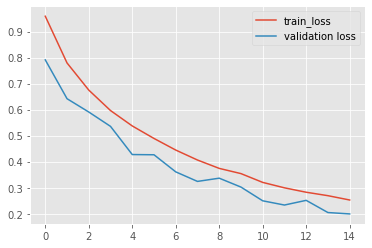

In [22]:
#今回は過学習もせずしっかりと出来ていることが分かる。
#仮にtrain_lossとvalidation_lossが乖離している場合は、過学習している可能性が高い。
plt.style.use("ggplot")
plt.plot(losses , label='train_loss')
plt.plot(val_losses , label="validation loss")
plt.legend()

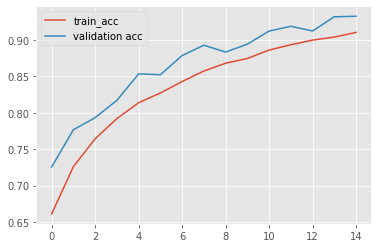

In [23]:
plt.plot(accs , label = "train_acc")
plt.plot(val_accs , label="validation acc")
plt.legend()

# 過学習を抑える方法
データ数を増やす方法がある。既存のデータからデータを水増しする。<br>
PyTorchでは水増しするために様々な操作が用意されている。<br>
データ拡張といっても実際に2万個の画像データから、6万個の画像データを生成するというわけではない。<br>
ただ、エポックごとに画像をランダムに反転させたり鮮度を変えたりしたものを使用するといった感じ。おんなじ2万枚でも画像が反転したりしたものを使用するといった感じ



In [24]:
val_transform = transforms.Compose([
                                transforms.ToTensor(),#Tensorclassに変えている。ChannelFirsｔに変換している。
                                transforms.Normalize((0.5,) , (0.5 , ))#平均値0.5標準偏差0.5になるように正規化を行っている。

])

train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),#ランダムに左右を入れ替えている。
                                transforms.ColorJitter(),#ランダムに画像の色調を変えている。
                                transforms.RandomRotation(10),#ランダムに画像の回転を行う。±10で回転する
                                transforms.ToTensor(),#Tensorclassに変えている。ChannelFirsｔに変換している。
                                transforms.Normalize((0.5,) , (0.5 , ))#平均値0.5標準偏差0.5になるように正規化を行っている。

])

#学習用データセット
train_dataset = datasets.CIFAR10(root="./data" , train=True , download=True , transform=train_transform)
#検証用データセット
validation_dataset = datasets.CIFAR10(root="./data" , train=True , download=True , transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
train_dataloader = DataLoader(train_dataset , batch_size=32 , shuffle=True)
validation_dataloader = DataLoader(validation_dataset , batch_size=32 , shuffle=False)

In [26]:
#CNNのクラスの定義を行う。


class CNN(nn.Module):
    def __init__(self , num_classes):#10個のクラスがあるのでnum_classesには10を代入する。
        super().__init__()
        self.features = nn.Sequential(
            #64個のフィルターを使用していく。カーネルサイズは５なので5＊5のフィルターになる。
            #5＊5のフィルターを使用するので画像の大きさを変えないためにpadding=2としている。ちなみにkarnel_sizeが3の時はpaddingは１
            nn.Conv2d(in_channels=3 , out_channels=64 , kernel_size=5,padding=2),#畳み込みを行っている
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#元の画像は32＊32なのでMAX_POOLINGを行うことによって16＊16の画像に縮小される。

            nn.Conv2d(in_channels= 64, out_channels=128 , kernel_size=3,padding=1),#inchannelsは前のout_channelsと同じ数でないとならない。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#8*8
            
            nn.Conv2d(in_channels=128 , out_channels=256 , kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#4*4

            nn.Conv2d(in_channels=256 , out_channels=128 , kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
        )

        #in_featuresには最後のMAX_POOLINGのチャネルの数（128）＊最後に出力されるMAX_POOLINGの大きさ（４＊４）
        #out_featuresは出力なので今回10クラスの分類を行うため10になる。
        self.classifier = nn.Linear(in_features=4*4*128,out_features=num_classes)#①

    def forward(self , x):
        x = self.features(x)#ここで出てくるのはｘ＝（32、128、４、４）
        x = x.view(x.size(0) , -1)#ここで一次のベクトル化を行っている。(32,4*4*128)
        x = self.classifier(x)#一時のベクトルに変換したものをここで①に入れている
        return x

In [27]:
model = CNN(10)#今回は10を引数に入れないといけないので入れた。
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = 0.001 , weight_decay=5e-4 )#weight_decayL2正則化を行っている。

In [29]:
num_epochs = 15
losses = []
accs = []

#検証用の損失と正解率
val_losses=[]
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs , labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output , labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output , dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

    #ここからvalidation loopを行っていく
    val_running_loss = 0.0
    val_running_acc = 0.0

    for val_imgs , val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output , val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output , dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch;{} , loss: {} , acc:{}, val loss: {} , val acc: {}".format(epoch ,running_loss , running_acc , val_running_loss , val_running_acc))

epoch;0 , loss: 1.4433954645637053 , acc:0.4703094959259033, val loss: 1.1595535401876966 , val acc: 0.5879318714141846
epoch;1 , loss: 1.030538660550987 , acc:0.6338571906089783, val loss: 0.8386631089185799 , val acc: 0.7073136568069458
epoch;2 , loss: 0.8754033244960367 , acc:0.6928582787513733, val loss: 0.7303101706413299 , val acc: 0.7468810081481934
epoch;3 , loss: 0.7841334348486084 , acc:0.7274672389030457, val loss: 0.6791577349468751 , val acc: 0.7645553350448608
epoch;4 , loss: 0.7266027986888922 , acc:0.7463411688804626, val loss: 0.6073153260630518 , val acc: 0.7941058874130249
epoch;5 , loss: 0.6878334357619514 , acc:0.7597968578338623, val loss: 0.5705134539709439 , val acc: 0.803622841835022
epoch;6 , loss: 0.6573756137816325 , acc:0.770333468914032, val loss: 0.5779222339220101 , val acc: 0.799884021282196
epoch;7 , loss: 0.6310828435577343 , acc:0.7812699675559998, val loss: 0.5564899356965445 , val acc: 0.806361973285675
epoch;8 , loss: 0.6151435516407607 , acc:0.78

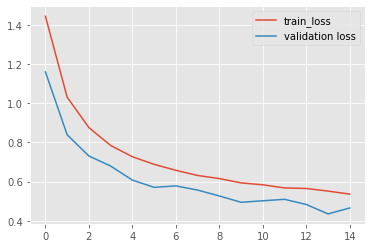

In [30]:
#今回は過学習もせずしっかりと出来ていることが分かる。
plt.style.use("ggplot")
plt.plot(losses , label='train_loss')
plt.plot(val_losses , label="validation loss")
plt.legend()

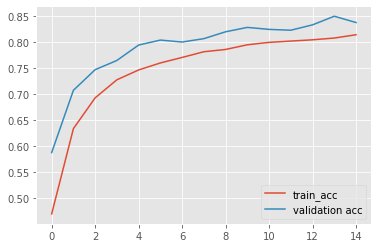

In [31]:
plt.plot(accs , label = "train_acc")
plt.plot(val_accs , label="validation acc")
plt.legend()